**Goals**

1. Set up a pipeline to incorporate the imputation
2. Do a random forest regressor to identify important features
3. Do a test run with one model (linear, most likely) that computes:
    - MSE for predicting PCIAT-Total
    - MSE for predicting sii when computed from predicted PCIAT-Total
    - MSE for predicting sii directly
    - kappa for predicting sii when computed from predicted PCIAT-Total
    - kappa for predicting sii directly
4. After getting the model working, measure these things for out-of-the box:
    - multiple linear regression
    - knn regression
    - random forest
    - support vector
    - gradient boost
    - adaboost
    - xgboost
5. After identifying a promising out-of-the-box model, try tuning it
6. Try implementing a sequential predictor (either logistic regression or random forest) that:
    - Starts by predicting 3's vs. non-threes
    - Predicts 2's vs. non-twos from the remaining cases
    - etc.
7. Try using different models for doing this sequential prediction

In [1]:
from imblearn.over_sampling import SMOTE

In [81]:
import pandas as pd
import numpy as np

# CustomImputers includes two imputers (using KNN and interative imputing) for this dataset
# and also two functions to transform fitnessgram values into fitnessgram zones, and to round sii values
from CustomImputers import *

**Loading the Data**

For the purpose of developing our model(s), we'll work with data that include the imputed outcome (PCIAT_Total and/or sii) scores AND have cleaned predictors.

In the final version of our code, we'll work with data with cleaned predictors but won't have any access to the outcome scores.

In [88]:
#Load the cleaned & outcome-imputed data
train_cleaned=pd.read_csv('train_cleaned_outcome_imputed.csv')

In [89]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

predictors_plus = predictors + ['PCIAT-PCIAT_Total']

**Constructing a Random Forest for Feature Identification**

**Note that this should be moved into a "Feature Selection" notebook along with the code to explore relationships between the various predictor variables**

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer


pipe_mice = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_mice.fit(train_cleaned[predictors],train_cleaned['PCIAT-PCIAT_Total'])

train_pred_mice = pipe_mice.predict(train_cleaned[predictors])

#Get feature importance from the rf inside pipe
score_mice_df = pd.DataFrame({'feature':train_cleaned[predictors].columns,
                            'importance_score': pipe_mice.named_steps['rf'].feature_importances_})

score_mice_df.sort_values('importance_score',ascending=False)


,feature,importance_score
0,Basic_Demos-Age,0.137804
4,Physical-Height,0.126698
24,PreInt_EduHx-computerinternet_hoursday,0.118666
18,BIA-BIA_FFM,0.077628
23,SDS-SDS_Total_Raw,0.074039
5,Physical-Weight,0.072494
26,ENMO_Avg_Active_Days_MVPA110,0.065296
11,FGC-FGC_CU,0.055829
19,BIA-BIA_FFMI,0.023911
13,FGC-FGC_PU,0.023766


In [59]:
keyfeatures = ['Basic_Demos-Age',
 'Physical-Height',
 'PreInt_EduHx-computerinternet_hoursday',
 'BIA-BIA_FFM',
 'SDS-SDS_Total_Raw',
 'Physical-Weight',
 'ENMO_Avg_Active_Days_MVPA110',
 'FGC-FGC_CU']

**Trying a Linear Model**

In this section, I'll make a linear model with a single predictor (hours spent on the internet)

Note: Column selector documented here: https://stackoverflow.com/questions/62416223/how-to-select-only-few-columns-in-scikit-learn-column-selector-pipeline

Note: custom loss functions for linear models are documented here: https://alexmiller.phd/posts/linear-model-custom-loss-function-regularization-python/

In [131]:
# First I'll see if I can get a pipe set up to do prediction on a split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer

from imblearn.over_sampling import SMOTE

# Need to import pipeline from imblearn instead of sklearn to be able to use SMOTE
#from imblearn.pipeline import Pipeline
#from sklearn.pipeline import Pipeline


# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 618, 2:316, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

train_tt, train_ho = train_test_split(train_cleaned, test_size=0.2)

mice = Custom_MICE_Imputer()
train_tt = mice.fit_transform(train_tt)
train_tt = zone_encoder(train_tt)
X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])
train_ho = mice.fit_transform(train_ho)
train_ho = zone_encoder(train_ho)

predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]

slr = Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())])


slr_endur = Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['Fitness_Endurance_Total_Time_Sec'])], remainder="drop")),
                ('linear', LinearRegression())])

mlr = LinearRegression()

slr.fit(X[predictors], X['PCIAT-PCIAT_Total'])
print('SLR MSE:', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], slr.predict(train_ho)))

slr_endur.fit(X[predictors], X['PCIAT-PCIAT_Total'])
print('SLR with fitness MSE:', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], slr_endur.predict(train_ho)))

templist = []
for item in predictors_less:
    templist = templist + [item]
    mlr.fit(X[templist], X['PCIAT-PCIAT_Total'])
    print('MLR MSE after adding',item,'is', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], mlr.predict(train_ho[templist])))


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


SLR MSE: 359.43514735752996
SLR with fitness MSE: 390.5092668223731
MLR MSE after adding Basic_Demos-Age is 345.5552865086136
MLR MSE after adding Basic_Demos-Sex is 350.2975504712902
MLR MSE after adding CGAS-CGAS_Score is 351.2103968749145
MLR MSE after adding Physical-BMI is 352.5336907511924
MLR MSE after adding Physical-Height is 348.3671900136879
MLR MSE after adding Physical-Weight is 349.3114493876744
MLR MSE after adding Physical-Waist_Circumference is 350.19409157318904
MLR MSE after adding Physical-Diastolic_BP is 350.4748934432094
MLR MSE after adding Physical-HeartRate is 350.3738311489927
MLR MSE after adding Physical-Systolic_BP is 350.6316296153886
MLR MSE after adding Fitness_Endurance-Max_Stage is 374.8621788588649
MLR MSE after adding FGC-FGC_CU is 349.80556142203983
MLR MSE after adding FGC-FGC_CU_Zone is 348.8735370570291
MLR MSE after adding FGC-FGC_PU is 346.9697521823393
MLR MSE after adding FGC-FGC_PU_Zone is 346.54014139093647
MLR MSE after adding FGC-FGC_TL i

**An Ordinal (Sequential Binary) Classifier**

**Note that this should be moved into a new python file that we then import into this notebook**

It looks like our attempts so far have under-predicted sii values of 2 and 3. 

We'll create a class that first predicts whether or not the sii value is 0, then continues upward...
This isn't quite the same as creating four separate binary predictors for 0, 1, 2, and 3 outcomes. We'll need to think about the code more to really know what it's doing.

I came up with this idea myself, but I wasn't the first one to do it. It was described on Medium: https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c from an article by Frank and Hal

Also described on stackoverflow: https://stackoverflow.com/questions/57561189/multi-class-multi-label-ordinal-classification-with-sklearn

Some discussion of the proposed code that highlights some of its issues is on stackoverflow: https://stackoverflow.com/questions/66486947/how-to-use-ordinal-classifier

**Note:** I'll need to modify this so that it can take parameter values as inputs to the self.clf

In [8]:
# This is something we should save in a separate file and then import
from sklearn.base import clone
from sklearn.metrics import accuracy_score

class OrdinalClassifier():

    def __init__(self, clf, **kwargs):
        self.clf = clf
        self.clf.set_params(**kwargs)
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0] - 1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                #print('binary_y has been fit for', self.unique_class[i])
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: v.predict_proba(X) for k, v in self.clfs.items()}
        predicted = []
        for i, y in enumerate(self.unique_class):
            #print('encoding for i=', i)
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:, 1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                predicted.append(clfs_predict[i - 1][:, 1] - clfs_predict[i][:, 1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i - 1][:, 1])
        return np.vstack(predicted).T

    def predict(self, X):
        return self.unique_class[np.argmax(self.predict_proba(X), axis=1)]
    
    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

**Comparing Models for Out-of-the-Box Performance**

**Part 1: Setting Up Models**

In the sections below, we'll set up a collection of un-tuned models and use them to predict sii scores. 

This first section instantiates the various models inside a dictionary that we'll use in the loop.

Note that we **aren't** using SMOTE here because we're (sometimes) going to predict PCIAT-PCIAT_Total rather than sii, and we want SMOTE to generate synthetic points based on sii.

Later, when we just want to predict sii, we can incorporate SMOTE into the pipeline

**Note: For this part, since we're going to run MICE and ZoneEncoder on train_tt and train_ho separately, we don't need to include these in the pipes. So we can probably take some of the models out of the pipes**

In [157]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier

# If we were including SMOTE in the pipeline, we'd need a different import statement
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

# Create classifiers to use as inputs to ordinal classifiers

# Note that the logistic regression is failing to converge.
# This can be addressed - see https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
# Here we're increasing max_iter from its default and also adding a standard scaler into its pipeline
# We could also adjust the solver, ad described here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
logisticc = LogisticRegression(max_iter=1000)

knnc=KNeighborsClassifier(10)
svc = SVC()
rfc = RandomForestClassifier()
# Note that the default for adaboost is the SAMME.R algorithm, but this will be deprecated in future releases. Switching to SAMME
adac = AdaBoostClassifier(algorithm='SAMME')
gradc = GradientBoostingClassifier()
xgbc = XGBClassifier()

#Note - for some reason, including Fitness_Endurance in MLR tanks its performance...
#'mlr_all' : LinearRegression(),
predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]


# List the various models we'll try to identify their "out of the box" performance
models = {
'slr_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_key_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_all_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', predictors_less)], remainder="drop")),
                ('linear', LinearRegression())]),

'knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn', KNeighborsRegressor(10))]),

'svr' : SVR(),

'rf': RandomForestRegressor(),

'ada' : AdaBoostRegressor(),

'grad' : GradientBoostingRegressor(),

'xgb': XGBRegressor(),

'ordinal_logistic_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('logistic_oc', OrdinalClassifier(logisticc))]),

'ordinal_knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn_ordinal', OrdinalClassifier(knnc))]),

# Note that SVC doesn't have a predict_proba method. This can be manually added later in a custom classifier; removing for now to facilitate completion...
#'ordinal_svc_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
#                ('add_zones', FunctionTransformer(zone_encoder)),
#                ('svc_ordinal', OrdinalClassifier(svc))]),

'ordinal_rf' : OrdinalClassifier(rfc),

'ordinal_ada' : OrdinalClassifier(adac),

'ordinal_grad': OrdinalClassifier(gradc),

'ordinal_xgb': OrdinalClassifier(xgbc)

}



**Comparing Models for Out-of-the-Box Performance**

**Part 2: Running Up Models**

The second section runs the models through a 5-fold split to compute kappa values.

We can predict sii scores in two ways:
1. Predict the PCIAT_Total score and then compute sii values
2. Predict the sii score directly

We can also modify some of these computations by adjusting the bins for computing sii values and by adjusting the computed sii scores manually.

One issue here is the extremely small number of sii=3 values in our data set. These are precisely the values we're most interested in predicting, since they most strongly indicate problematic internet use.

A suggestion from stackoverflow is to over-sample the sii=3 instances; we've implemented this over-sampling inside the k-fold split to try to avoid data leakage:
https://stackoverflow.com/questions/39512140/how-to-deal-with-this-unbalanced-class-skewed-data-set

Note: Column selector documented here: https://stackoverflow.com/questions/62416223/how-to-select-only-few-columns-in-scikit-learn-column-selector-pipeline

**NOTE ABOUT OVERSAMPLING MINORITY CLASSES**

We're trying to do this manually below. But it is also possible to do this in a more sophisticated way with SMOTE:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In short, rather than just copying existing instances of sii=3 cases (which is what we're doing below), SMOTE creates new "synthetic" data points of class sii=3 using knn.

This seems not-too-hard to implement, but since we're so pressed for time, I'm not going to try to add it in here.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 618, 2:316, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Set up a list of the models and methods to organize the computation of means in the kfold split
modellist = []
for pipeline_name, pipeline_obj in models.items():
    modellist.append(pipeline_name)

methodlist = ['Compute SII from PCIAT (Standard Bins) (kappa)', 
                'Compute SII from PCIAT (Modified Bins) (kappa)',
                'Predict SII (rounded) (kappa)']

num_splits = 5

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((len(methodlist), len(modellist), num_splits))

#Make a StratifiedKFold object stratified by the variable sii
# This is necessary due to the small number of sii=3 values
kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0
for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    #The next four lines will use SMOTE to oversample 
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    # j will enumerate the model
    j=0

    for pipeline_name, pipeline_obj in models.items():
        # The ordinal predictors can't predict PCIAT scores, so we'll leave them out of the first round of computations
        if 'ordinal' in pipeline_name:
            kappa_sii_comp = 0
            kappa_sii_comp_mod = 0
        else:
            # Fit and make predictions of PCIAT_Total
            pipeline_obj.fit(X[predictors_less], X['PCIAT-PCIAT_Total'])
            pred = pipeline_obj.predict(train_ho[predictors_less])

            # Compute sii based on PCIAT
            bins = [0, 30, 49,79,100]
            pred_bin = np.digitize(pred, bins)-1

            # Try a slightly different set of bins suggested by the "tuning" below
            bins_mod = [0, 27, 39, 79, 100]
            pred_bin_mod = np.digitize(pred, bins_mod)-1

            # Compute kappa values
            kappa_sii_comp = cohen_kappa_score(train_ho['sii'], pred_bin, weights='quadratic')
            kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
        
        # Store the kappa values in the output array
        output[0,j,i] = kappa_sii_comp
        output[1,j,i] = kappa_sii_comp_mod
        j=j+1

    j=0
    for pipeline_name, pipeline_obj in models.items():
        # Fit and make predictions of sii
        pipeline_obj.fit(X[predictors], y)
        pred = pipeline_obj.predict(train_ho[predictors])

        # Round the predictors to compute kappa
        pred_round = np.round(pred)

        # Compute and record the kappa values
        kappa_sii_round = cohen_kappa_score(train_ho['sii'], pred_round, weights='quadratic')

        output[2,j,i] = kappa_sii_round
        j=j+1
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_avg = np.mean(output, axis=2)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [142]:
# create a data frame from output using modellist as the names of the columns and methodlist as the names of the rows
output_df = pd.DataFrame(output_avg, columns=modellist, index=methodlist)

output_df

,slr_pipe,mlr_key_pipe,mlr_all_pipe,knn_pipe,svr,rf,ada,grad,xgb,ordinal_logistic_pipe,ordinal_knn_pipe,ordinal_rf,ordinal_ada,ordinal_grad,ordinal_xgb
Compute SII from PCIAT (Standard Bins) (kappa),0.285168,0.425278,0.424666,0.358441,0.290397,0.387783,0.393958,0.393643,0.329852,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Compute SII from PCIAT (Modified Bins) (kappa),0.327925,0.450071,0.452007,0.393163,0.356923,0.427487,0.422144,0.428248,0.356758,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Predict SII (rounded) (kappa),0.279098,0.405045,0.403168,0.355492,0.337821,0.364814,0.178433,0.382274,0.340921,0.403168,0.279755,0.284312,0.329401,0.397881,0.35175
Predict SII (+0.1 rounded) (kappa),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


**Results of OOtB Investigation**

* The multiple regression - both using all predictors and using just the "key" features had among the largest kappa values.
* Gradient Boosting - both as a regressor and inside an ordinal classifier - was at or near the top of kappa values.
* Logistic regression inside an ordinal classifier did well
* Random forest performed decently for predicting PCIAT scores and then computing sii values
* XGBoost performed decently for predicting sii values both via regression and inside an ordinal classifier.

In general, adjusting the predicted sii values decreased kappa.

Predicting PCIAT and then computing sii benefitted from adjusting the cutpoints.

In the sections below, we'll "tune" the cutpoints and then try tuning a few of the models and re-testing the loop.

**Tuning the Bins**

We noticed that our model struggled to predict higher output values.

When we adjusted the values for converting PCIAT scores to sii scores, we noticed an improvement in prediction when we lowered the cutpoints.

We sought to "tune" these cutpoints. However, we need to be mindful of overfitting. 

We'll look at the combination of cutpoints that maximize kappa, and then from the top 20 (or so) select the cutpoints that are closest to the original ones (as measured by euclidean distance)

In [ ]:
# We'll use the multiple linear regression with "key" features to test the cutpoints
# This model performed as good or better than most of the other (untuned) models
# Since it is quick to run, it should be a decent choice for doing this tuning

# Start by setting up the MLR pipeline
mlr_key_pipe=Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())])

# Set the number of k-fold splits
num_splits = 5

# Set the number of different cutpoints to try
num_bincuts=15

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((num_bincuts, num_bincuts,num_bincuts, num_splits))

#Make a KFold object, stratified on sii=3 values
kfold= StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0

for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    #The next four lines will use SMOTE to oversample 
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)
    
    # Fit the pipe and make predictions
    mlr_key_pipe.fit(train_tt[predictors], train_tt['PCIAT-PCIAT_Total'])
    pred = mlr_key_pipe.predict(train_ho[predictors])

    # Iterate through values of the three cutpoints    
    for r in range(num_bincuts):
        for s in range(num_bincuts):
            for t in range(num_bincuts):
                bins = [0, 30-r, 49-s,79-t,100]
                pred_bin_mod = np.digitize(pred, bins)-1
                # Compute kappa for the binned predictions
                kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
                output[r,s,t,i]=kappa_sii_comp_mod
                
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_avg = np.mean(output, axis=3)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Next, we'll examine the output of the tuning

In [140]:
# Flatten the array and sort the indices in descending order
sorted_indices_flat = np.argsort(output_avg.ravel())[::-1]

#Decide how many top values you want to look at. 
n=20

# Get the flat indices of the top two values
top_flat_indices = sorted_indices_flat[:n]

# Convert the flat indices to 3D indices
top_indices = [np.unravel_index(idx, output_avg.shape) for idx in top_flat_indices]

# Retrieve the top two values
top_values = output_avg.ravel()[top_flat_indices]

print("Top values:", top_values)
print("Locations of the top values:", top_indices)

Top values: [0.45205028 0.45205028 0.45205028 0.45165227 0.45165227 0.45165227
 0.45165227 0.45165227 0.45165227 0.45165227 0.45165227 0.45165227
 0.45165227 0.45165227 0.45165227 0.45076378 0.45076378 0.45076378
 0.45057336 0.45057336]
Locations of the top values: [(3, 10, 13), (3, 10, 12), (3, 10, 14), (3, 10, 5), (3, 10, 11), (3, 10, 10), (3, 10, 9), (3, 10, 7), (3, 10, 6), (3, 10, 8), (3, 10, 4), (3, 10, 3), (3, 10, 2), (3, 10, 1), (3, 10, 0), (3, 11, 13), (3, 11, 12), (3, 11, 14), (3, 13, 13), (3, 13, 12)]


**Results of Cutpoint Tuning: First Round**

Of the top 20 cutpoints, the combination that minimizes the Euclidean distance between the original and new cutpoints is:
[0, 30-3, 49-6,79-8,100] = [0, 27, 43, 71, 100]

**Results of Cutpoint Tuning: Second Round**

Of the top 20 cutpoints, the combination that minimizes the Euclidean distance between the original and new cutpoints is:
[0, 30-3, 49-11,79-0,100] = [0, 27, 38, 79, 100]

**Results of Cutpoint Tuning: Third Round**

Of the top 20 cutpoints, the combination that minimizes the Euclidean distance between the original and new cutpoints is:
[0, 30-3, 49-10,79-0,100] = [0, 27, 39, 79, 100]

We'll circle back around and try this in the loop above.

**Hyperparameter Tuning**

The models above were run "out of the box." In the next sections, we'll try to tune a few of them (random forest, gradient boost, logistic regression inside an ordinal classifier, and, maybe, xgboost) to see how much we can improve their performance.

**Tuning the Random Forest Regressor**

In this section, we'll tune the random forest regressor.

Note that using a pipeline with gridcvsearch requires slightly different naming conventions for the parameter grid: 
https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid

Additional suggestions for only applying preprocessing before doing the gridsearchcv (not sure if we need this):
https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Below is the initial parameter grid we're trying
param_grid = {
    'rf__n_estimators': [50, 100, 200, 500],
    'rf__max_depth': range(1,10),
    'rf__min_samples_split': [2, 4, 8]
}

#Below is the last round of parameters we're trying after several iterations
#param_grid = {
#    'rf__n_estimators': [90, 95, 100, 105, 110],
#    'rf__max_depth': [6],
#    'rf__min_samples_split': [4]
#}

# Instantiate a random forest pipeline
rf_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('rf', RandomForestRegressor())])

grid_cv_rf = GridSearchCV(rf_pipe, 
                          param_grid = param_grid, 
                          cv = 5,
                          return_train_score=True)

# We'll start by tuning on PCIAT, and can tune separately on sii
grid_cv_rf.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])


KeyboardInterrupt: 

In [16]:
# Report the results
print('Best parameters:',grid_cv_rf.best_params_)
print('Best score:',grid_cv_rf.best_score_)

Best parameters: {'rf__max_depth': 6, 'rf__min_samples_split': 4, 'rf__n_estimators': 105}
Best score: 0.2789071515246433


**Results from GridSearch for Random Forest Regressor**

The first run took 30 minutes using the following parameter grid:
* 'rf__n_estimators': [50, 100, 200, 500],
* 'rf__max_depth': range(1,10),
* 'rf__min_samples_split': [2, 4, 8]

The best parameters, achieving a score of 0.28379 were:
* max_depth: 6
* min_samples_split: 4
* n_estimators: 100

The second run took 4 minutes, using a narrower ranges of parameters:
* 'rf__n_estimators': [75, 100, 150],
* 'rf__max_depth': range(4,7),
* 'rf__min_samples_split': [3, 4, 5]

The best parameters, achieving a score of 0.28396 were:
* max_depth: 6
* min_samples_split: 4
* n_estimators: 100

We will try one more search, further narrowing the ranges:
* 'rf__n_estimators': [90, 95, 100, 105, 110],
* 'rf__max_depth': [6],
* 'rf__min_samples_split': [4]

The best parameters, achieving a score of 0.2812376 were:
* n_estimators: 105

We noticed that this score was lower than the previous run, so we tried re-running. This time, the best parameters, achieving a score of 0.280982 were:
* n_estimators: 110

A third run yielded a score of 0.2808725 with
* n_estimators: 95

So it seems like the original set of best parameters (6, 4, 100) will likely 

**Checking Random Forest (for PCIAT) for Overfitting**

We can look at the mean_train_scores and mean_test_scores reported for each of the combinations of hyperparameters

In [17]:
# Check for overfitting

print(grid_cv_rf.cv_results_.keys())
print(grid_cv_rf.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_rf.cv_results_["mean_test_score"].shape)

print(grid_cv_rf.cv_results_["mean_train_score"])
print(grid_cv_rf.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(5,)
(5,)
[0.51507384 0.51536063 0.51574856 0.51557561 0.51465788]
[0.27645075 0.27675516 0.27687953 0.27890715 0.27705007]


In [ ]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_rf.cv_results_["mean_test_score"]==grid_cv_rf.best_score_)
print('Best mean_train_score:', grid_cv_rf.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_rf.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
rf_results_df = pd.DataFrame({'mean_train_score': grid_cv_rf.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_rf.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
rf_results_df['ratio'] = rf_results_df['mean_train_score']/rf_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = rf_results_df['ratio'].quantile(0.25)
Q3 = rf_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = rf_results_df[(rf_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (rf_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
rf_sii_results_df = rf_results_df[~rf_results_df['ratio'].isin(outliers['ratio'])]

import matplotlib.pyplot as plt

# Create a histogram of ratio
plt.hist(rf_results_df['ratio'], bins=20)
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

**Tuning Random Forest for Predicting sii**

In the section above, we trained a random forest regressor to predict PCIAT scores.

Next, we'll train it for sii scores. 

GridSearchCV doesn't include kappa as a built-in metric. In addition, RF will use regression to predict sii scores, and these will need to be rounded.

So we'll need to make a custom scorer to evaluate the models.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer
#Importing classes to use SMOTE in a pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 618, 2:316, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

#Below is the initial parameter grid we used
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': range(1,11),
    'rf__min_samples_split': [2, 4, 8]
}

#Below is the last iteration of the parameter grid we used
#param_grid = {
#    'rf__n_estimators': [50, 75, 100],
#    'rf__max_depth': range(5, 7),
#    'rf__min_samples_split': [8, 10, 12]
#}

# Instantiate a random forest pipeline
rf_pipe_sii = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('over', oversample),
                ('rf', RandomForestRegressor())])

grid_cv_rf_sii = GridSearchCV(rf_pipe_sii, 
                          param_grid = param_grid, 
                          scoring = kappa_scorer, 
                          cv = 5,
                          return_train_score = True)

grid_cv_rf_sii.fit(train_cleaned[predictors], train_cleaned['sii'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x17f17dd00>)),
                                       ('over',
                                        SMOTE(sampling_strategy={0: 1228,
                                                                 1: 618, 2: 316,
                                                                 3: 128})),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': range(5, 7),
                         'rf__min_samples_split': [8, 10, 12],
                         'rf__n_estimators': [50, 75, 100]},
             return_train_score=True,
             scoring=make_scorer(sii_kappa, response_method='predict'))

In [19]:
# Report the results
print('Best parameters:',grid_cv_rf_sii.best_params_)
print('Best score:',grid_cv_rf_sii.best_score_)

Best parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 12, 'rf__n_estimators': 75}
Best score: 0.4052480707564469


**Results from GridSearch for Random Forest Regressor for sii**

The first run took 14 minutes using the following parameter grid:
* 'rf__n_estimators': [50, 100, 200],
* 'rf__max_depth': range(1,11),
* 'rf__min_samples_split': [2, 4, 8]

The best parameters, achieving a score of 0.36574 were:
* max_depth: 8
* min_samples_split: 8
* n_estimators: 50

The second run took 4 minutes, using a narrower ranges of parameters:
* 'rf__n_estimators': [25, 50, 75],
* 'rf__max_depth': range(5,7),
* 'rf__min_samples_split': [6, 8, 10]

The best parameters, achieving a score of 0.364877 were:
* max_depth: 6
* min_samples_split: 10
* n_estimators: 75

We will try one more search, further narrowing the ranges:
* 'rf__n_estimators': [50, 75, 100],
* 'rf__max_depth': range(5, 7),
* 'rf__min_samples_split': [8, 10, 12]

The best parameters, achieving a score of 0.3576324 were:
* max_depth: 6
* min_samples_split: 10
* n_estimators: 50

Re-running, The best parameters, achieving a score of 0.35866 were:
* max_depth: 6
* min_samples_split: 8
* n_estimators: 50

Re-running one more time WITH SMOTE, the best parameters, achieving a score of 0.40938 were
* max_depth: 5
* min_samples_split: 8
* n_estimators: 75

So it seems like the set of best parameters (6, 8, 50) will likely be ideal

**Check for Overfitting**

In [ ]:
print(grid_cv_rf_sii.cv_results_.keys())
print(grid_cv_rf_sii.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_rf_sii.cv_results_["mean_test_score"].shape)

print(grid_cv_rf_sii.cv_results_["mean_train_score"])
print(grid_cv_rf_sii.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(18,)
(18,)
[0.5392894  0.55346812 0.55218566 0.55083666 0.54584734 0.54135521
 0.55354219 0.54483194 0.55335276 0.6149572  0.61575062 0.61317262
 0.61922829 0.60693003 0.60571842 0.61412286 0.60870465 0.61241786]
[0.40359675 0.39298661 0.39910933 0.39069313 0.39882425 0.39718183
 0.39302239 0.40524807 0.38911738 0.39387456 0.38899677 0.38008117
 0.37669518 0.39090786 0.39220953 0.38772109 0.38874749 0.38539509]


Best mean_train_score: [0.54483194]
Best mean_test_score: [0.40524807]


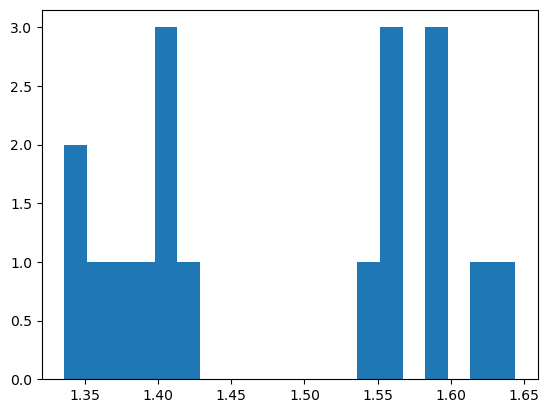

In [153]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_rf_sii.cv_results_["mean_test_score"]==grid_cv_rf_sii.best_score_)
print('Best mean_train_score:', grid_cv_rf_sii.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_rf_sii.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
rf_sii_results_df = pd.DataFrame({'mean_train_score': grid_cv_rf_sii.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_rf_sii.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
rf_sii_results_df['ratio'] = rf_sii_results_df['mean_train_score']/rf_sii_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = rf_sii_results_df['ratio'].quantile(0.25)
Q3 = rf_sii_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = rf_sii_results_df[(rf_sii_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (rf_sii_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
rf_sii_results_df = rf_sii_results_df[~rf_sii_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(rf_sii_results_df['ratio'], bins=20)
plt.show()

**Tuning Gradient Boosting Regressor for PCIAT**

There are lots of parameters to consider here.

Starting to format the parameter grid using suggestions from StackOverflow: https://stackoverflow.com/questions/49500313/tune-parameters-in-gradient-boosting-reggression-with-cross-validation-sklearn

Thinking about parameters based on other articles:
* https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Note that we have a total of ~2500 observations with PCIAT scores in the entire dataset, a very small (32) number of scores with sii=3 and a relatively small number of scores with sii=2

Thus, we can limit the depth to 10 and also include relatively low values for min_samples, but should be very cautious about overfitting with small leaves and deep trees.

In [ ]:
param_grid = {
    'grad__learning_rate': [0.5, 0.1, 0.05],
    'grad__max_depth': np.linspace(3, 6, 4, endpoint=True).astype(int),
    'grad__max_features': np.linspace(1,30, 5).astype(int),
    'grad__min_samples_leaf': [5, 8, 11],
    'grad__min_samples_split': np.linspace(2, 10, 3, endpoint=True).astype(int),
    'grad__n_estimators': [10, 50, 100, 200]
}

# Going to boost the number of sii=3 values in the data set
## Note - this is potentially problematic. We should only be boosting the sii=3 values in the tt set but not the holdout set
## So we should probably try re-running this without the boost (or do the grid search manually...)

# As above, we're going to "boost" the number of observations with sii=3 to try to improve predictive performance
#train_cleaned_sii3=train_cleaned[train_cleaned['sii']==3]
#train_cleaned_sii3=pd.concat([train_cleaned_sii3]*4, ignore_index=True)
#train_tt=pd.concat([train_cleaned,train_cleaned_sii3], ignore_index=True)
#train_tt.reset_index(drop=True, inplace=True)

# Instantiate a gradient boosting regressor pipeline
grad_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('grad', GradientBoostingRegressor())])

grid_cv_grad = GridSearchCV(grad_pipe, 
                          param_grid = param_grid, 
                          cv = 5,
                          return_train_score=True)

# We'll start by tuning on PCIAT, and can tune separately on sii
grid_cv_grad.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x17f17dd00>)),
                                       ('grad', GradientBoostingRegressor())]),
             param_grid={'grad__learning_rate': [0.5, 0.1, 0.05],
                         'grad__max_depth': array([3, 4, 5, 6]),
                         'grad__max_features': array([ 1,  8, 15, 22, 30]),
                         'grad__min_samples_leaf': [5, 8, 11],
                         'grad__min_samples_split': array([ 2,  6, 10]),
                         'grad__n_estimators': [10, 50, 100, 200]},
             return_train_score=True)

In [22]:
# Report the results
print('Best parameters:',grid_cv_grad.best_params_)
print('Best score:',grid_cv_grad.best_score_)

Best parameters: {'grad__learning_rate': 0.05, 'grad__max_depth': 3, 'grad__max_features': 15, 'grad__min_samples_leaf': 11, 'grad__min_samples_split': 6, 'grad__n_estimators': 100}
Best score: 0.29702336780221594


**Tuning Results**

Best parameters: 
* 'grad__learning_rate': 0.05
* 'grad__max_depth': 3
* 'grad__max_features': 15
* 'grad__min_samples_leaf': 11
* 'grad__min_samples_split': 6
* 'grad__n_estimators': 100

In [23]:
# Check for overfitting

print(grid_cv_grad.cv_results_.keys())
print(grid_cv_grad.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_grad.cv_results_["mean_test_score"].shape)

print(grid_cv_grad.cv_results_["mean_train_score"])
print(grid_cv_grad.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_grad__learning_rate', 'param_grad__max_depth', 'param_grad__max_features', 'param_grad__min_samples_leaf', 'param_grad__min_samples_split', 'param_grad__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(2160,)
(2160,)
[0.32567509 0.52932406 0.64963349 ... 0.62466125 0.73533973 0.8471008 ]
[0.20676159 0.19012964 0.15285339 ... 0.26846015 0.26131398 0.23777669]


In [ ]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_grad.cv_results_["mean_test_score"]==grid_cv_grad.best_score_)
print('Best mean_train_score:', grid_cv_grad.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_grad.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
grad_results_df = pd.DataFrame({'mean_train_score': grid_cv_grad.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_grad.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
grad_results_df['ratio'] = grad_results_df['mean_train_score']/grad_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = grad_results_df['ratio'].quantile(0.25)
Q3 = grad_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = grad_results_df[(grad_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (grad_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
grad_results_df = grad_results_df[~grad_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(grad_results_df['ratio'], bins=20)
plt.show()

Best mean_train_score: [0.4382191]
Best mean_test_score: [0.29702337]


**Tuning the Gradiant Boosting Regressor for sii**

In [24]:
param_grid = {
    'grad__learning_rate': [0.5, 0.1, 0.05],
    'grad__max_depth': np.linspace(3, 6, 4, endpoint=True).astype(int),
    'grad__max_features': np.linspace(1,30, 5).astype(int),
    'grad__min_samples_leaf': [5, 8, 11],
    'grad__min_samples_split': np.linspace(2, 10, 3, endpoint=True).astype(int),
    'grad__n_estimators': [10, 50, 100, 200]
}

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)


# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 618, 2:316, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Instantiate a gradient boosting regressor pipeline
grad_pipe_sii = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('over', oversample),
                ('grad', GradientBoostingRegressor())])

grid_cv_grad_sii = GridSearchCV(grad_pipe_sii, 
                          param_grid = param_grid, 
                          scoring = kappa_scorer,
                          cv = 5,
                          return_train_score=True)

grid_cv_grad_sii.fit(train_cleaned[predictors], train_cleaned['sii'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x17f17dd00>)),
                                       ('over',
                                        SMOTE(sampling_strategy={0: 1228,
                                                                 1: 618, 2: 316,
                                                                 3: 128})),
                                       ('grad', GradientBoostingRegressor())]),
             param_grid={'grad__learning_rate': [0.5, 0.1, 0.05],
                         'grad__max_depth': array([3, 4, 5, 6]),
                         'grad__max_features': array([ 1,  8, 15, 22, 30]),
                         'grad__min_samples_leaf': [5, 8, 11],
                         'grad__min_samples_split': array([ 2,  6, 10]),
                         'grad__n_estimators': [10, 50, 100, 200]},
             return_train_score=True,
             scoring=make_scorer(sii_kappa, response_method='predict'))

In [25]:
# Report the results
print('Best parameters:',grid_cv_grad_sii.best_params_)
print('Best score:',grid_cv_grad_sii.best_score_)

Best parameters: {'grad__learning_rate': 0.1, 'grad__max_depth': 3, 'grad__max_features': 8, 'grad__min_samples_leaf': 8, 'grad__min_samples_split': 2, 'grad__n_estimators': 100}
Best score: 0.4261362901285259


**Tuning Results**
Best parameters
* 'grad__learning_rate': 0.1
* 'grad__max_depth': 3
* 'grad__max_features': 8
* 'grad__min_samples_leaf': 8
* 'grad__min_samples_split': 2
* 'grad__n_estimators': 100

In [26]:
# Check for overfitting

print(grid_cv_grad_sii.cv_results_.keys())
print(grid_cv_grad_sii.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_grad_sii.cv_results_["mean_test_score"].shape)

print(grid_cv_grad_sii.cv_results_["mean_train_score"])
print(grid_cv_grad_sii.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_grad__learning_rate', 'param_grad__max_depth', 'param_grad__max_features', 'param_grad__min_samples_leaf', 'param_grad__min_samples_split', 'param_grad__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(2160,)
(2160,)
[0.426134   0.60826088 0.70881255 ... 0.71805537 0.81939705 0.90198569]
[0.31578599 0.35481764 0.33909108 ... 0.37988662 0.38742159 0.38485522]


Best mean_train_score: [0.59531635]
Best mean_test_score: [0.42613629]


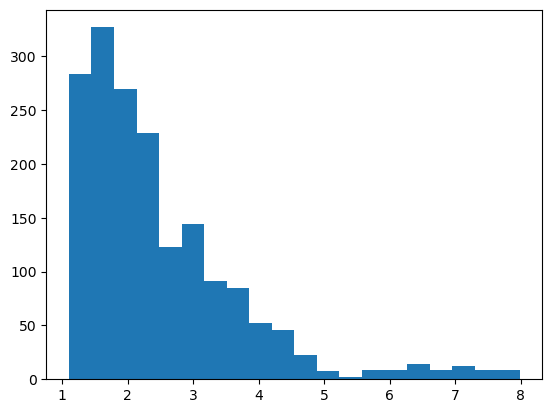

In [152]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_grad_sii.cv_results_["mean_test_score"]==grid_cv_grad_sii.best_score_)
print('Best mean_train_score:', grid_cv_grad_sii.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_grad_sii.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
grad_sii_results_df = pd.DataFrame({'mean_train_score': grid_cv_grad_sii.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_grad_sii.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
grad_sii_results_df['ratio'] = grad_sii_results_df['mean_train_score']/grad_sii_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = grad_sii_results_df['ratio'].quantile(0.25)
Q3 = grad_sii_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = grad_sii_results_df[(grad_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (grad_sii_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
grad_sii_results_df = grad_results_df[~grad_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(grad_sii_results_df['ratio'], bins=20)
plt.show()

**Manually Tuning Logistic Regression Inside an Ordinal Classifier**

GridSearchCV doesn't seem to be able to pass parameter values into a model wrapped in an ordinal classifier. So we'll tune this manually.

In [33]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

## import kfold
from sklearn.model_selection import StratifiedKFold

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)

## set the number of CV folds
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, shuffle=True)

C_params = [0.001,0.01,0.1,0.5, 1,5, 10,20, 50, 70, 100, 150, 200]

lr_test_kappas = np.zeros((n_splits, len(C_params)))
lr_train_kappas = np.zeros((n_splits, len(C_params)))

for i,(train_index, test_index) in enumerate(kfold.split(train_cleaned[predictors], train_cleaned['sii'])):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    # Do the duplication here

    for j, cval in enumerate(C_params):
        #print(i,j)
        ordinal_logistic_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
            ('add_zones', FunctionTransformer(zone_encoder)),
            ('over', oversample),
            ('scale', StandardScaler()),
            ('logistic_oc', OrdinalClassifier(LogisticRegression(max_iter=1000, C=cval)))])
                                        
        ordinal_logistic_pipe.fit(train_tt[predictors], train_tt['sii'])
        
        pred_test = ordinal_logistic_pipe.predict(train_ho[predictors])
        pred_train = ordinal_logistic_pipe.predict(train_tt[predictors])
        
        lr_test_kappas[i,j] = sii_kappa(train_ho['sii'],  pred_test)
        lr_train_kappas[i,j] = sii_kappa(train_tt['sii'],  pred_train)

In [34]:
# Get optimal value of C
max_index = np.unravel_index(np.argmax(np.mean(lr_test_kappas, axis=0)), 
                                       np.mean(lr_test_kappas, axis=0).shape)


print(C_params[max_index[0]])

0.1


**Check for Overfitting**

In [35]:
# Compare kappas
mean_test_kappas = np.mean(lr_test_kappas, axis=0)
mean_train_kappas = np.mean(lr_test_kappas, axis=0)
print('Means of C-values of', C_params,'for test set are',mean_test_kappas)
print('Means of C-values of', C_params,'for train set are',mean_train_kappas)

Means of C-values of [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 100, 150, 200] for test set are [0.18772281 0.34290345 0.39525086 0.37362701 0.37276992 0.37801866
 0.37263625 0.38783868 0.38181823 0.37391351 0.37145925 0.37346962
 0.37724703]
Means of C-values of [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 100, 150, 200] for train set are [0.18772281 0.34290345 0.39525086 0.37362701 0.37276992 0.37801866
 0.37263625 0.38783868 0.38181823 0.37391351 0.37145925 0.37346962
 0.37724703]


**Retesting with Optimized Parameters**

In [187]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier

# If we were including SMOTE in the pipeline, we'd need a different import statement
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

# Create classifiers to use as inputs to ordinal classifiers

# Note that the logistic regression is failing to converge.
# This can be addressed - see https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
# Here we're increasing max_iter from its default and also adding a standard scaler into its pipeline
# We could also adjust the solver, ad described here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
logisticc = LogisticRegression(max_iter=1000, C=0.1)

knnc=KNeighborsClassifier(10)
svc = SVC()
rf = RandomForestClassifier()
#rfc_best = grid_cv_rf.best_estimator_
# Note that the default for adaboost is the SAMME.R algorithm, but this will be deprecated in future releases. Switching to SAMME
adac = AdaBoostClassifier(algorithm='SAMME')
gradc = GradientBoostingClassifier()
#Note that .best_estimator is a regressor, and we need classifiers here
#gradc_pciat = grid_cv_grad.best_estimator_
#gradc_sii = grid_cv_grad_sii.best_estimator_
# For some reason, we can't just call back to the best_params_ result...???
#gradc_sii = GradientBoostingClassifier(grid_cv_grad_sii.best_params_)
gradc_pciat = GradientBoostingClassifier(learning_rate=0.05, max_depth= 3, max_features= 15, min_samples_leaf= 11, min_samples_split= 6, n_estimators= 100)
gradc_sii = GradientBoostingClassifier(learning_rate=0.1, max_depth= 3, max_features= 8, min_samples_leaf= 8, min_samples_split= 2, n_estimators= 100)

xgbc = XGBClassifier()

#Note - for some reason, including Fitness_Endurance in MLR tanks its performance...
#'mlr_all' : LinearRegression(),
predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]


# List the various models we'll try to identify their "out of the box" performance
models = {
'slr_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_key_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_all_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', predictors_less)], remainder="drop")),
                ('linear', LinearRegression())]),

'knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn', KNeighborsRegressor(10))]),

'svr' : SVR(),

'rf': RandomForestRegressor(),
#'rf_best': grid_cv_rf.best_estimator_,

'ada' : AdaBoostRegressor(),

'grad' : GradientBoostingRegressor(),
'grad_pciat': grid_cv_grad.best_estimator_,
'gradc_sii' : GradientBoostingRegressor(learning_rate=0.1, max_depth= 3, max_features= 8, min_samples_leaf= 8, min_samples_split= 2, n_estimators= 100),
#'grad_sii': grid_cv_grad_sii.best_estimator_,

'xgb': XGBRegressor(),

'ordinal_logistic_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('logistic_oc', OrdinalClassifier(logisticc))]),

'ordinal_knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn_ordinal', OrdinalClassifier(knnc))]),

'ordinal_rf' : OrdinalClassifier(rfc),
#'ordinal_rf_best' : OrdinalClassifier(rfc_best),

'ordinal_ada' : OrdinalClassifier(adac),

'ordinal_grad': OrdinalClassifier(gradc),
'ordinal_grad_pciat': OrdinalClassifier(gradc_pciat),
'ordinal_grad_sii': OrdinalClassifier(gradc_sii),

'ordinal_xgb': OrdinalClassifier(xgbc)

}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 618, 2:316, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Set up a list of the models and methods to organize the computation of means in the kfold split
modellist = []
for pipeline_name, pipeline_obj in models.items():
    modellist.append(pipeline_name)

methodlist = ['Compute SII from PCIAT (Standard Bins) (kappa)', 
                'Compute SII from PCIAT (Modified Bins) (kappa)',
                'Predict SII (rounded) (kappa)']

num_splits = 5

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((len(methodlist), len(modellist), num_splits))

#Make a StratifiedKFold object stratified by the variable sii
# This is necessary due to the small number of sii=3 values
kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0
for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    #The next four lines will use SMOTE to oversample 
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    # j will enumerate the model
    j=0

    for pipeline_name, pipeline_obj in models.items():
        # The ordinal predictors can't predict PCIAT scores, so we'll leave them out of the first round of computations
        if 'ordinal' in pipeline_name:
            kappa_sii_comp = 0
            kappa_sii_comp_mod = 0
        else:
            # Fit and make predictions of PCIAT_Total
            pipeline_obj.fit(X[predictors_less], X['PCIAT-PCIAT_Total'])
            pred = pipeline_obj.predict(train_ho[predictors_less])

            # Compute sii based on PCIAT
            bins = [0, 30, 49,79,100]
            pred_bin = np.digitize(pred, bins)-1

            # Try a slightly different set of bins suggested by the "tuning" below
            bins_mod = [0, 27, 39, 79, 100]
            pred_bin_mod = np.digitize(pred, bins_mod)-1

            # Compute kappa values
            kappa_sii_comp = cohen_kappa_score(train_ho['sii'], pred_bin, weights='quadratic')
            kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
        
        # Store the kappa values in the output array
        output[0,j,i] = kappa_sii_comp
        output[1,j,i] = kappa_sii_comp_mod
        j=j+1

    j=0
    for pipeline_name, pipeline_obj in models.items():
        # Fit and make predictions of sii
        pipeline_obj.fit(X[predictors], y)
        pred = pipeline_obj.predict(train_ho[predictors])

        # Round the predictors to compute kappa
        pred_round = np.round(pred)

        # Compute and record the kappa values
        kappa_sii_round = cohen_kappa_score(train_ho['sii'], pred_round, weights='quadratic')

        output[2,j,i] = kappa_sii_round
        j=j+1
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_tuned_avg = np.mean(output, axis=2)

trying slr_pipe
trying mlr_key_pipe
trying mlr_all_pipe
trying knn_pipe
trying svr
trying rf
trying ada
trying grad
trying grad_pciat
trying gradc_sii
trying xgb
trying ordinal_logistic_pipe
trying ordinal_knn_pipe
trying ordinal_rf
trying ordinal_ada
trying ordinal_grad
trying ordinal_grad_pciat
trying ordinal_grad_sii
trying ordinal_xgb
trying slr_pipe for predicting sii
trying mlr_key_pipe for predicting sii
trying mlr_all_pipe for predicting sii
trying knn_pipe for predicting sii
trying svr for predicting sii
trying rf for predicting sii
trying ada for predicting sii
trying grad for predicting sii
trying grad_pciat for predicting sii
trying gradc_sii for predicting sii
trying xgb for predicting sii
trying ordinal_logistic_pipe for predicting sii
trying ordinal_knn_pipe for predicting sii
trying ordinal_rf for predicting sii
trying ordinal_ada for predicting sii
trying ordinal_grad for predicting sii
trying ordinal_grad_pciat for predicting sii
trying ordinal_grad_sii for predicting

KeyboardInterrupt: 

In [ ]:
# create a data frame from output using modellist as the names of the columns and methodlist as the names of the rows
output_tuned_df = pd.DataFrame(output_tuned_avg, columns=modellist, index=methodlist)

output_tuned_df